# **Dobra, jakis tytul trzeba tu wymyślić** #

## **1. Basic imports** ##

In [5]:
from river.datasets import synth
from river.drift import ADWIN
from river import evaluate, metrics, ensemble, drift, tree

import matplotlib.pyplot as plt

## **2. Creating concept drift stream** ##

### **2.1 Different Concept Drift Generators** ###

#### **SEA** ####

Ten generator jest fajny, ale trzeba zmienić variant zeby były rózne. Inaczej wygeneują się dwa niemal identyczne strumienie.

In [6]:
stream_SEA = synth.ConceptDriftStream(
    stream=synth.SEA(seed=42, variant=0),
    drift_stream=synth.SEA(seed=42, variant=3),
    position=500,
    width=10,
    seed=1
)

#### **Hyperplane** ####

In [7]:
stream_Hyperplane = synth.ConceptDriftStream(
    stream=synth.Hyperplane(n_features=2, seed=42),
    drift_stream=synth.Hyperplane(n_features=2, seed=42),
    position=500,
    width=100,
    seed=1
)

In [8]:
stream_Hyperplane = synth.Hyperplane(
    n_features=2,
    noise_percentage=0.0,
    mag_change=0.01,
    seed=42
)

#### **RandomRBF** ####

To jest trochę crazy i coś tam coś tam ze jakies centroidy, ale nie wygląda to tak ładnie jak SEA

In [9]:
stream_RBF = synth.ConceptDriftStream(
    stream=synth.RandomRBF(n_features=2),
    drift_stream=synth.RandomRBF(n_features=2),
    position=500,
    width=10,
    seed=1
)

### **2.2 Visualization of data drift** ###

In [10]:
def visualize_drift(stream, n):
    """
    Visualizes the data points before and after a concept drift in a 2D feature space.

    Parameters:
    - stream: A data stream object that yields (features, label) tuples.
    - n: Total number of samples to take from the stream for visualization. Drift starts at n/2.
    """
    X, y = [], []
    for x, label in stream.take(n):
        X.append(x)
        y.append(label)

    # Convert to lists of features
    f1 = [row[0] for row in X]
    f2 = [row[1] for row in X]

    # Plot before and after drift
    plt.figure(figsize=(12, 5))

    # Before drift
    plt.subplot(1, 2, 1)
    plt.scatter(f1[:n//2], f2[:n//2], c=y[:n//2], cmap="coolwarm", s=20, alpha=0.7)
    plt.title("Before Drift")
    plt.xlabel("att0")
    plt.ylabel("att1")

    # After drift
    plt.subplot(1, 2, 2)
    plt.scatter(f1[n//2:], f2[n//2:], c=y[n//2:], cmap="coolwarm", s=20, alpha=0.7)
    plt.title("After Drift")
    plt.xlabel("att0")
    plt.ylabel("att1")

    plt.tight_layout()
    plt.show()

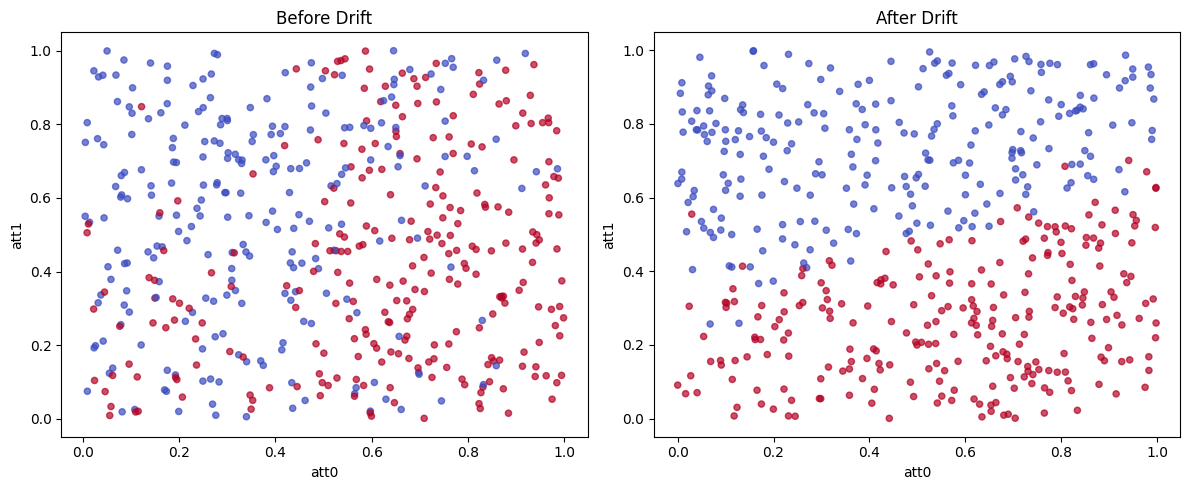

In [11]:
visualize_drift(stream_Hyperplane, 1000)

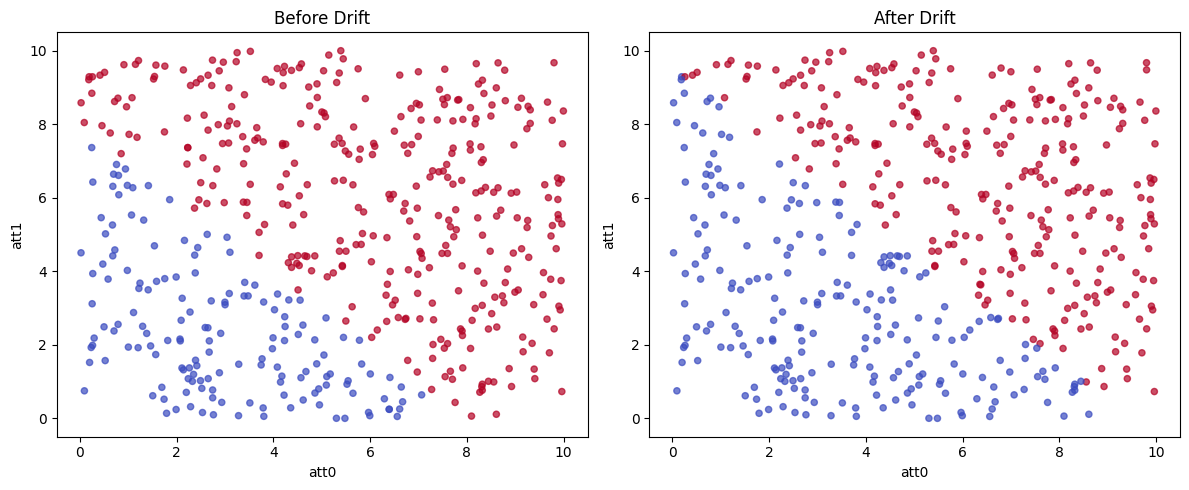

In [12]:
visualize_drift(stream_SEA, 1000)

## **3. Model training and drift detection with ADWIN** ##

In [19]:
n = 1000
X, y = [], []

for x, label in stream_SEA.take(n):
    X.append([x[i] for i in x.keys()])
    y.append(label)

[False,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 Tru

Drift detected at sample 991


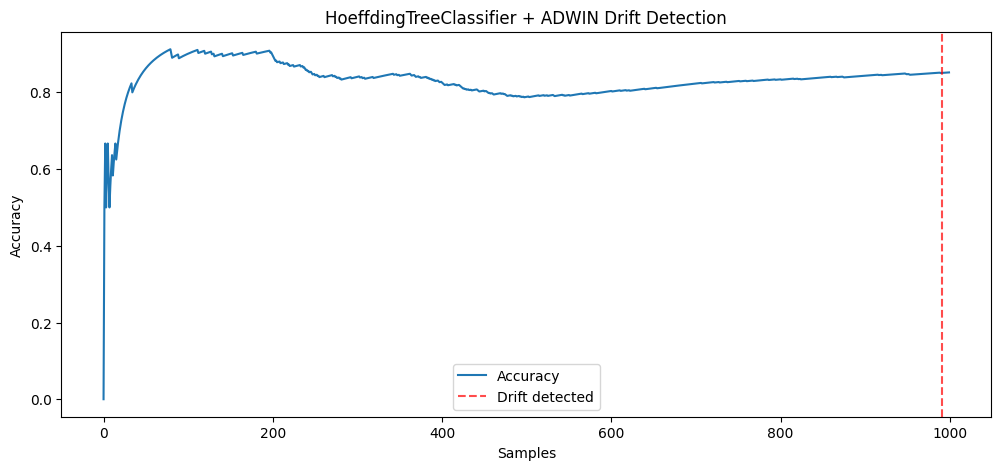

In [15]:
adwin = ADWIN()
model = tree.HoeffdingTreeClassifier()
metric = metrics.Accuracy()

accuracies = []
drift_points = []

for i, (x, y) in enumerate(stream_Hyperplane.take(n)):
    y_pred = model.predict_one(x)
    model.learn_one(x, y)

    metric.update(y, y_pred)
    accuracies.append(metric.get())

    error = int(y_pred is not None and y != y_pred)
    adwin.update(error)

    if adwin.drift_detected:
        drift_points.append(i)
        print(f"Drift detected at sample {i}")

# 6. Plot results
plt.figure(figsize=(12,5))
plt.plot(accuracies, label="Accuracy")
for dp in drift_points:
    plt.axvline(dp, color="red", linestyle="--", alpha=0.7, label="Drift detected" if dp == drift_points[0] else "")
plt.xlabel("Samples")
plt.ylabel("Accuracy")
plt.title("HoeffdingTreeClassifier + ADWIN Drift Detection")
plt.legend()
plt.show()

To jest tak na szybko robione. Trzeba tak zrobic zeby dzialalo tez dla SEA